In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve,auc
import seaborn as sns
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


## 1. Data preprocessing

- The merged dataset containers data leakage features which are features that wouldnt be available in real-world prediction such as `max_delay`, `avg_delay`, `num_bad_months`, `months_total`. The target variable `label`, `id` and `amt_income_total` (to use the log transformed income) are also dropped. The target variable `label` is converted to integer for classification
- Applied one-hot encoding to categorical variables 
- Applied train-test split and SMOTE

In [2]:
df = pd.read_csv("../data/clean_merged.csv")


In [3]:
y = df['label'].astype('int')
leaky_features = ['max_delay', 'avg_delay', 'num_bad_months', 'months_total']
X = df.drop(columns=['label', 'id', 'amt_income_total'] + leaky_features)



In [4]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True) #one-hot encoding
else:
    X_encoded = X

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
X_train.head()

,code_gender,flag_own_car,flag_own_realty,cnt_children,flag_mobil,flag_work_phone,flag_phone,flag_email,cnt_fam_members,age,...,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Unknown,occupation_type_Waiters/barmen staff
8361,1,0,1,2,1,0,0,0,4,44,...,False,False,False,False,False,False,False,False,True,False
24270,0,1,0,2,1,1,1,0,4,26,...,False,False,False,False,False,False,False,False,False,False
14938,1,1,1,1,1,0,0,0,3,29,...,False,False,False,False,False,False,False,False,False,False
29783,1,1,1,1,1,0,0,0,3,51,...,False,True,False,False,False,False,False,False,False,False
18805,0,1,1,0,1,0,0,1,2,42,...,False,False,False,False,False,False,False,False,True,False


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23996 entries, 8361 to 14621
Data columns (total 48 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   code_gender                                        23996 non-null  int64  
 1   flag_own_car                                       23996 non-null  int64  
 2   flag_own_realty                                    23996 non-null  int64  
 3   cnt_children                                       23996 non-null  int64  
 4   flag_mobil                                         23996 non-null  int64  
 5   flag_work_phone                                    23996 non-null  int64  
 6   flag_phone                                         23996 non-null  int64  
 7   flag_email                                         23996 non-null  int64  
 8   cnt_fam_members                                    23996 non-null  int64  
 9   age     

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# apply SMOTE 
smote = SMOTE(random_state=42)
X_balance, y_balance = smote.fit_resample(X_train, y_train)
print(f"Class distribution of y after SMOTE: {Counter(y_balance)}")
print(f"Class distribution of y without SMOTE: {Counter(y_test)}")

Class distribution of y after SMOTE: Counter({0: 23531, 1: 23531})
Class distribution of y without SMOTE: Counter({0: 5884, 1: 116})


## 2. Random Forest Model (Baseline)

### 2.1 Baseline model

Random Forest is an ensemble learning method based on building multiple decision trees during training and combining their predictions by majority vote for classification. 

This makes the model:
- Generalise better and avoid overfitting
- Handle non-linear relationships
- Automatically estimate feature importance

The first model is a baseline model that is simple and unoptimised version that uses the original imbalanced data with default Random Forest hyperparameters to provide a reference point.

In [8]:
# Train Random forest classifier
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))  # y_test loaded as true test targets

print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

print(f"\nRates:")

total_0 = cm[0,0] + cm[0,1]  
total_1 = cm[1,0] + cm[1,1] 

print(f"\nSpecificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")

Accuracy: 0.9786666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      5884
           1       0.34      0.11      0.17       116

    accuracy                           0.98      6000
   macro avg       0.66      0.55      0.58      6000
weighted avg       0.97      0.98      0.97      6000


Confusion Matrix:
 [[5859   25]
 [ 103   13]]

Rates:

Specificity (True Negative Rate): 0.9958
False Positive Rate: 0.0042
Sensitivity (Recall/True Positive Rate): 0.1121
False Negative Rate: 0.8879


### 2.2 Baseline Model (using only the top 10 most important features)

Rationale for reducing to top 10 most important features:
- Interpretability 
- Eliminates noisy or irrelevant features that might affect accuracy of model
- Reduce likelihood of model learning random patterns 
- Fewer inputs = Increase training efficiency

In [9]:
# Get feature importances and feature names
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Make a DataFrame for easy sorting/viewing
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feat_imp_df

,feature,importance
9,age,0.176366
12,amt_income_log,0.173468
11,years_employed,0.171135
8,cnt_fam_members,0.040446
0,code_gender,0.030556
1,flag_own_car,0.030214
6,flag_phone,0.028802
2,flag_own_realty,0.027511
3,cnt_children,0.024645
13,name_income_type_Pensioner,0.021184


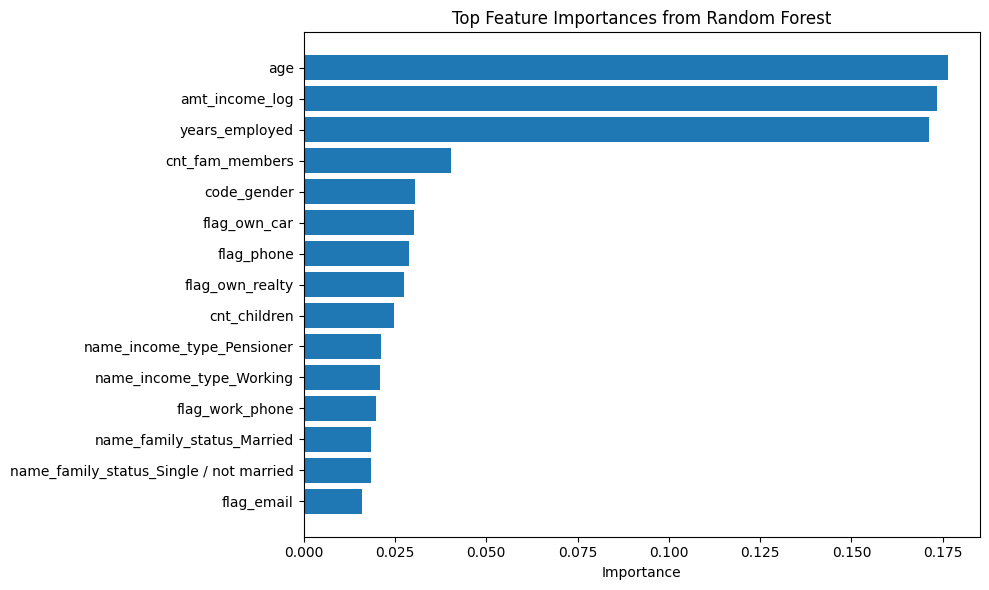

In [10]:
# Plot top N features (e.g. top 15)
N = 15
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['feature'][:N][::-1], feat_imp_df['importance'][:N][::-1])
plt.xlabel('Importance')
plt.title('Top Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

In [11]:
print(feat_imp_df.head(10))  # Show top 10 important features

                       feature  importance
9                          age    0.176366
12              amt_income_log    0.173468
11              years_employed    0.171135
8              cnt_fam_members    0.040446
0                  code_gender    0.030556
1                 flag_own_car    0.030214
6                   flag_phone    0.028802
2              flag_own_realty    0.027511
3                 cnt_children    0.024645
13  name_income_type_Pensioner    0.021184


In [12]:
# reduce train and test to selected features

N = 10
top_features = feat_imp_df['feature'].iloc[:N].tolist()
top_features

X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

In [13]:
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = rf_reduced.predict(X_test_reduced)

print("Accuracy with reduced features:", accuracy_score(y_test, y_pred_reduced))

print("\nClassification Report:\n", classification_report(y_test, y_pred_reduced))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_reduced))

Accuracy with reduced features: 0.9785

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      5884
           1       0.34      0.12      0.18       116

    accuracy                           0.98      6000
   macro avg       0.66      0.56      0.58      6000
weighted avg       0.97      0.98      0.97      6000


Confusion Matrix:
 [[5857   27]
 [ 102   14]]


After feature reduction:
- Accuracy improved slightly: 0.9809380142622052 to 0.9810751508502469 
- Recall for target label 0 (no approval) is still 1.00
- Recall for target label 1 (approval) improved slightly: 0.15 to 0.16


In [14]:
y_proba_reduced = rf_reduced.predict_proba(X_test_reduced)[:, 1]  # Probability of class '1'
fpr, tpr, thresholds = roc_curve(y_test, y_proba_reduced)  # y_test = true labels
# Calculate AUC
auc_score = roc_auc_score(y_test, y_proba_reduced)
print(f"AUC: {auc_score:.3f}")

AUC: 0.769


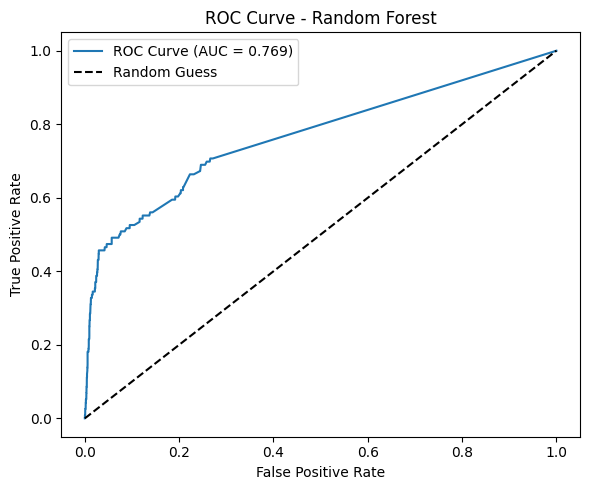

In [15]:
# Plot the ROC Curve
plt.figure(figsize = (6, 5))
plt.plot(fpr, tpr, label = f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.tight_layout()
plt.show()

### 2.3 GridSearchCV to find the best combination of hyperparameters for Random Forest Model 

Rationale for GridSearchCV:
- We want to improve model performance (measured by ROC-AUC) by testing different parameter settings (n_estimators, max_depth, min_samples_split) systematically.

Key Random Forest hyperparameters:
- `n_estimators`: Number of trees in the Random Forest. Having more trees can improve model performance but increase training time. 
- `max_depth`: Maximum depth of each tree which controls the model complexity
- `min_samples_split`: Minimum samples required to split a node. Larger `min_samples_split` prevents overfitting as it requires more samples to create a split.

#### How the GridSearchCV works?

GridSearchCV tries every combination in the grid, using cross-validation (CV) to evaluate each combination. We chose cv = 3 (3-fold CV splits), splits the data into 3 parts. The model is trained 3 rounds, each round, the model is trained on a different 2/3 of the data. This CV ensures the model generalises well.

In [16]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state = 42),
    param_grid,
    cv = 3,
    scoring = 'roc_auc',
    n_jobs = 1,       # <<< Only use 1 job (no parallel, less stress on env)
    verbose = 2
)
grid_rf.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   3.0s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   2.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END max_depth=None, m

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 5, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200]}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [17]:
print("Best Random Forest params:", grid_rf.best_params_)
print("Best cross-validated AUC:", grid_rf.best_score_)

Best Random Forest params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validated AUC: 0.7233385325905207


The performance of the optimal hyperparameter combination identified by GridSearchCV was evaluated using the ROC-AUC metric.

ROC-AUC measures how well the Random Forest model separates the 2 classes (defaulters vs. non-defaulters)

Rationale for using ROC-AUC:
- We have identified the dataset to be imbalanced, so using accuracy metric can be misleading. A model that always predicts the majority class could still appear "accurate", even though it performs poorly on the minority class. Thus, the model might fail to identify important minority cases, like defaulters, which could cause harm to the bank.
- In contrast, ROC-AUC looks at how well the model separates defaulters vs. non-defaulters, so it is much more reliable compared to accuracy metric.

In [18]:
# Evaluate the Best Model on Test Set
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Predict probabilities (for AUC) and classes
y_proba = grid_rf.best_estimator_.predict_proba(X_test_reduced)[:, 1]
y_pred = grid_rf.best_estimator_.predict(X_test_reduced)

# Evaluate
print("Test set ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test set ROC AUC: 0.7590089430131977
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      5884
           1       0.29      0.09      0.13       116

    accuracy                           0.98      6000
   macro avg       0.64      0.54      0.56      6000
weighted avg       0.97      0.98      0.97      6000

Confusion Matrix:
 [[5860   24]
 [ 106   10]]


Based on the Classification Report, even though the ROC-AUC shows a high value of 0.80, the recall value is low, and false negative rate is very high (0.88). In the financial institution context, type II error which is the false negative rate might be a greater consequence. The model would approve a credit card for someone who is actually a bad customer (likely to default) the bank loses money if the applicant with a poor credit history gets approved, and later fails to pay. Hence, to improve on this, section 3 contains different enhancements made to the baseline model to improve the performance metrics.

## 3. Random Forest Model Enhancements / Variants

### 3.1 Random Forest Model with SMOTE and Fixed Hyperparameters

In [19]:


rf_model_smote = RandomForestClassifier(
    n_estimators = 100,        # no. of trees
    max_depth = 10,           
    min_samples_split = 20,   
    min_samples_leaf = 10,
    max_features = 'sqrt',     # random feature selection, diff trees see different subset of features 
    bootstrap = True,          # bagging, ensemble learning
    random_state = 42,
    n_jobs = -1               # for parallel processing
)

rf_model_smote.fit(X_balance, y_balance)

#  predictions
y_pred_smote = rf_model_smote.predict(X_test)
y_pred_proba_smote = rf_model_smote.predict_proba(X_test)[:, 1]

# performance metrics 
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_smote)
pr_auc = auc(recall, precision)


print(f"Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_smote):.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))

# confusion Matrix
cm = confusion_matrix(y_test, y_pred_smote)
print("Confusion Matrix:")
print(cm)

print(f"\nRates:")
total_0 = cm[0,0] + cm[0,1]  
total_1 = cm[1,0] + cm[1,1] 


print(f"Specificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")



Accuracy: 0.8898
ROC AUC: 0.6425
PR AUC: 0.0448

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      5884
           1       0.05      0.27      0.09       116

    accuracy                           0.89      6000
   macro avg       0.52      0.58      0.51      6000
weighted avg       0.97      0.89      0.92      6000

Confusion Matrix:
[[5308  576]
 [  85   31]]

Rates:
Specificity (True Negative Rate): 0.9021
False Positive Rate: 0.0979
Sensitivity (Recall/True Positive Rate): 0.2672
False Negative Rate: 0.7328


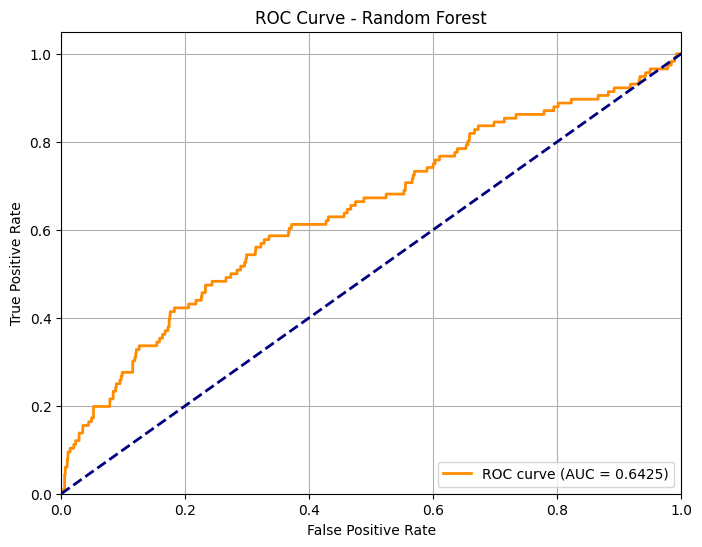

In [20]:
# Plot ROC curve 
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_smote):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Issues with random forest model using training set balanced using smote:

1. AUC of 0.6 is only slightly better than random guesssing, contradicts the 0.90 accuracy rate. The accuracy rate might be misleading because majority class dominates (`label` = 0 for non default). The model might not be discriminating well between the 2 classes. 

2. Although recall increased from the baseline model (0.20 from 0.11), the trade off is lower precision and f1 score as these are nearly 0 for `label` = 1. Since the minority class is extremely small (about 0.02%), SMOTE might produce unrealisitc synthetic minority points, and the model might be overfitting to the SMOTE-generated data by learning the artificial patterns created by SMOTE but not generalizing well to the test set. Some features are dominated by 0s or categorical dummies.

3. Potential changes made to this model: 
 - to lower the threshold to 0.3 from 0.5 to capture more defaulters (true positives) (refer to section 3.2)
 - to change to class_weight="balanced" to replace SMOTE (refer to section 3.4)
 - change the model with features that are engineered (refer to section 3.4)

### 3.2 Random Forest Model (adjusted threshold)

In [21]:
rf_model_thres = RandomForestClassifier(
    n_estimators=100,        # no. of trees
    max_depth=10,           
    min_samples_split=20,   
    min_samples_leaf=10,
    max_features='sqrt',     # random feature selection, diff trees see different subset of features 
    bootstrap=True,          # bagging, ensemble learning
    random_state=42,
    n_jobs=-1               # for parallel processing
)

rf_model_thres.fit(X_balance, y_balance)

y_pred_thres = rf_model_thres.predict(X_test)
y_pred_proba_thres = rf_model_thres.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_adj = (y_pred_proba_thres >= threshold).astype(int)


# performance metrics 
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_thres)
pr_auc = auc(recall, precision)


print(f"Accuracy: {accuracy_score(y_test, y_pred_adj):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_thres):.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adj))

# confusion Matrix
cm = confusion_matrix(y_test, y_pred_adj)
print("Confusion Matrix:")
print(cm)

print(f"\nRates:")
total_0 = cm[0,0] + cm[0,1]  
total_1 = cm[1,0] + cm[1,1] 

print(f"Specificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")


Accuracy: 0.5453
ROC AUC: 0.6425
PR AUC: 0.0448

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.54      0.70      5884
           1       0.03      0.64      0.05       116

    accuracy                           0.55      6000
   macro avg       0.51      0.59      0.38      6000
weighted avg       0.97      0.55      0.69      6000

Confusion Matrix:
[[3198 2686]
 [  42   74]]

Rates:
Specificity (True Negative Rate): 0.5435
False Positive Rate: 0.4565
Sensitivity (Recall/True Positive Rate): 0.6379
False Negative Rate: 0.3621


Recall for `label` = 1 increase significantly (0.6) but at the cost of much lower precision, F1-score and accuracy. Most non-defaulters are now wrongly flagged as defaulters. Adjusting threshold does not quite solve the issue since the model cannot tell defaulters apart confidently. Even at threshold 0.3, only a small group of samples truly correspond to real defaulters.

### 3.3 Random Forest Model with Class-Weight Balancing Instead of SMOTE) 


To address the severe class imbalance in the dataset, we trained a Random Forest with class_weight='balanced'. This approach automatically assigns higher importance to the minority class (defaulters) during training, without generating synthetic samples as in SMOTE.

In [22]:

rf_model_cw = RandomForestClassifier(
    n_estimators = 200,
    max_depth = 15,
    min_samples_leaf = 5,
    min_samples_split = 10,
    max_features = 'sqrt',
    class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
)

rf_model_cw.fit(X_train, y_train)


y_pred_cw = rf_model_cw.predict(X_test)
y_pred_proba_cw = rf_model_cw.predict_proba(X_test)[:, 1] 

cv_scores_rf = cross_val_score(rf_model_cw, X_train, y_train, cv = 5, scoring = 'roc_auc')
print(f"Cross-Validation AUC: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_cw)
pr_auc = auc(recall, precision)


print(f"Accuracy: {accuracy_score(y_test, y_pred_cw):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_cw):.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\n Classification Report")
print(classification_report(y_test, y_pred_cw))


print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_cw)
print(cm)

print(f"\nRates:")

total_0 = cm[0,0] + cm[0,1]  
total_1 = cm[1,0] + cm[1,1] 

print(f"Specificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")



Cross-Validation AUC: 0.6830 (+/- 0.0415)
Accuracy: 0.9515
ROC AUC: 0.7112
PR AUC: 0.1466

 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5884
           1       0.17      0.40      0.24       116

    accuracy                           0.95      6000
   macro avg       0.58      0.68      0.61      6000
weighted avg       0.97      0.95      0.96      6000

Confusion Matrix:
[[5663  221]
 [  70   46]]

Rates:
Specificity (True Negative Rate): 0.9624
False Positive Rate: 0.0376
Sensitivity (Recall/True Positive Rate): 0.3966
False Negative Rate: 0.6034


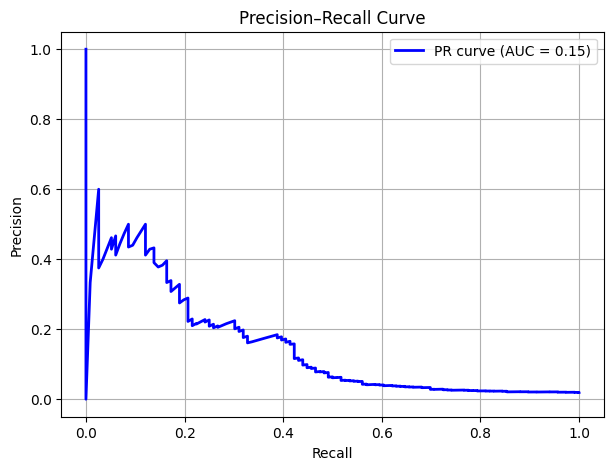

In [23]:
# Precision recall curve
plt.figure(figsize=(7,5))
plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Most of the performance metric values improved quite a bit from the model that uses smote especially recall, false negative rate, pr auc which are most important as having high false negative rate can be quite costly if a defaulter is wrongly predicted as non-defaulter. Even though PR AUC improved slightly, but the model may be doing slightly better than random guessing only because the features might not provide enough information to distinguish between defaulters and non-defaulters. The model still struggles to detect the minority class effectively. Feature engineering will be done under the section 2.4

### 3.4 Random Forest Model  With Feature Engineering

####   3.4.1 Check feature importance

                     feature  importance
11            years_employed    0.160557
9                        age    0.152307
12            amt_income_log    0.138161
8            cnt_fam_members    0.043751
3               cnt_children    0.032079
2            flag_own_realty    0.031902
1               flag_own_car    0.029517
6                 flag_phone    0.027710
16  name_income_type_Working    0.024644
0                code_gender    0.024104


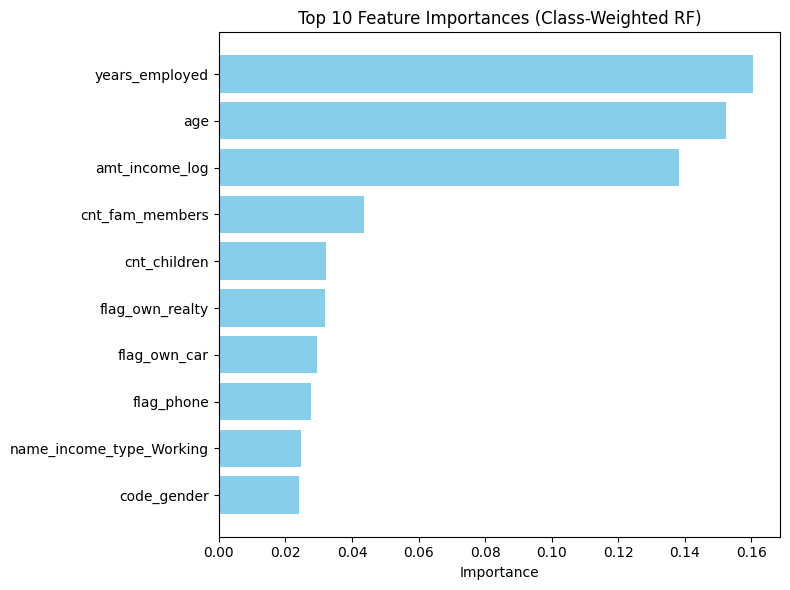

In [24]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_model_cw.feature_importances_
}).sort_values('importance', ascending = False)

print(feature_importance.head(10))

top_features = feature_importance.head(10)

# Plot
plt.figure(figsize=(8,6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Class-Weighted RF)')
plt.tight_layout()
plt.show()


Based on the feature importance for the top 10 features, only the top 3 features seem to have predictive power as all other features have importance of less than 0.01. 

#### 3.4.2 Feature Engineering

In [25]:

import warnings
warnings.filterwarnings('ignore')

def new_features(X):
   
    X_eng = X.copy()
    
    # use ratio
    if 'years_employed' in X.columns and 'age' in X.columns:
        X_eng['career_ratio'] = X['years_employed'] / (X['age'] + 1)
        X_eng['employment_stability'] = X['years_employed'] / (X['age'] - 18 + 1)  # Years since adult
    
    if 'amt_income_log' in X.columns and 'cnt_fam_members' in X.columns:
        X_eng['income_per_member'] = X['amt_income_log'] / (X['cnt_fam_members'] + 1)
        X_eng['log_income_per_member'] = np.log1p(X_eng['income_per_member'])
    
    # interaction terms
    if 'age' in X.columns and 'amt_income_log' in X.columns:
        X_eng['age_income_interaction'] = X['age'] * X['amt_income_log']
        X_eng['age_income_ratio'] = X['age'] / (X['amt_income_log'] + 1)
    
    # nonlinear transf
    if 'age' in X.columns:
        X_eng['age_squared'] = X['age'] ** 2
        X_eng['age_cubed'] = X['age'] ** 3
        X_eng['log_age'] = np.log1p(X['age'])
    
    if 'years_employed' in X.columns:
        X_eng['employment_squared'] = X['years_employed'] ** 2
        X_eng['log_employment'] = np.log1p(X['years_employed'] + 1)
    

    return X_eng

# apply the feature engineering defined above
X_engineered = new_features(X_encoded)

# use one-hot encoding for cat variables
categorical_eng_cols = X_engineered.select_dtypes(include=['object', 'category']).columns
if len(categorical_eng_cols) > 0:
    X_engineered = pd.get_dummies(X_engineered, columns=categorical_eng_cols, drop_first=True)

X_train_eng, X_test_eng, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42, stratify=y
)

#  feature selection using correlation with target
correlations = X_train_eng.corrwith(y_train).abs().sort_values(ascending=False)

# select top correlated features
selected_features = correlations[correlations > 0.01].index.tolist()
if len(selected_features) < 20: 
    selected_features = correlations.head(30).index.tolist()

print(f"Selected {len(selected_features)} features for modeling")

X_train_selected = X_train_eng[selected_features]
X_test_selected = X_test_eng[selected_features]



Selected 30 features for modeling


#### 3.4.3 Modelling

In [26]:
rf_engineered = RandomForestClassifier(
    n_estimators=400,
    max_depth=22,
    min_samples_leaf=2,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_engineered.fit(X_train_selected, y_train)


cv_scores = cross_val_score(rf_engineered, X_train_selected, y_train, 
                           cv=5, scoring='roc_auc', n_jobs=-1)
print(f"Cross-Validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

y_pred_eng = rf_engineered.predict(X_test_selected)
y_pred_proba_eng = rf_engineered.predict_proba(X_test_selected)[:, 1]



Cross-Validation AUC: 0.7104 (+/- 0.0474)


#### 3.4.4 Evaluation of Performance Metrics

In [27]:
def evaluation(model_name, y_test, y_pred, y_pred_proba, feature_names, model):
    print(f"\n{model_name} Evaluation")


    roc_auc_value = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    pr_precision, pr_recall, _ = precision_recall_curve(y_test, y_pred_proba_eng)
    pr_auc_value = auc(pr_recall, pr_precision)


    print(f"ROC AUC: {roc_auc_value:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"PR AUC:  {pr_auc_value:.4f}") 
    
    # Confusion Matrix
    print(f"\nConfusion Matrix")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("\n Classification Report")
    print(classification_report(y_test, y_pred))
   
    total_0 = cm[0,0] + cm[0,1]
    total_1 = cm[1,0] + cm[1,1]

    print(f"\nRates:")

    print(f"Specificity (True Negative Rate): {cm[0,0]/total_0:.4f}")
    print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
    print(f"Sensitivity (Recall/True Positive Rate): {cm[1,1]/total_1:.4f}")
    print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")

    # for plotting in part 2.4.5
    return {
        'roc_auc': roc_auc_value,
        'pr_auc': pr_auc_value,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'confusion_matrix': cm
    }
#1.  evaluate engineered model
results_eng = evaluation(
    "===Random Forest with Feature Engineering===", 
    y_test, y_pred_eng, y_pred_proba_eng, 
    selected_features, rf_engineered
)


# 2.  train "baseline" model (using class weight (rf_model_cw), no feature engineering)

results_cw = evaluation(
    "===Random Forest (No Engineering)===", 
    y_test, y_pred_cw, y_pred_proba_cw, 
    X_train.columns, rf_model_cw
)


===Random Forest with Feature Engineering=== Evaluation
ROC AUC: 0.7386
Accuracy: 0.9447
PR AUC:  0.1468

Confusion Matrix
[[5620  264]
 [  68   48]]

 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5884
           1       0.15      0.41      0.22       116

    accuracy                           0.94      6000
   macro avg       0.57      0.68      0.60      6000
weighted avg       0.97      0.94      0.96      6000


Rates:
Specificity (True Negative Rate): 0.9551
False Positive Rate: 0.0449
Sensitivity (Recall/True Positive Rate): 0.4138
False Negative Rate: 0.5862

===Random Forest (No Engineering)=== Evaluation
ROC AUC: 0.7112
Accuracy: 0.9515
PR AUC:  0.1468

Confusion Matrix
[[5663  221]
 [  70   46]]

 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5884
           1       0.17      0.40      0.24       116

    accuracy  

#### 3.4.5 Visualisation

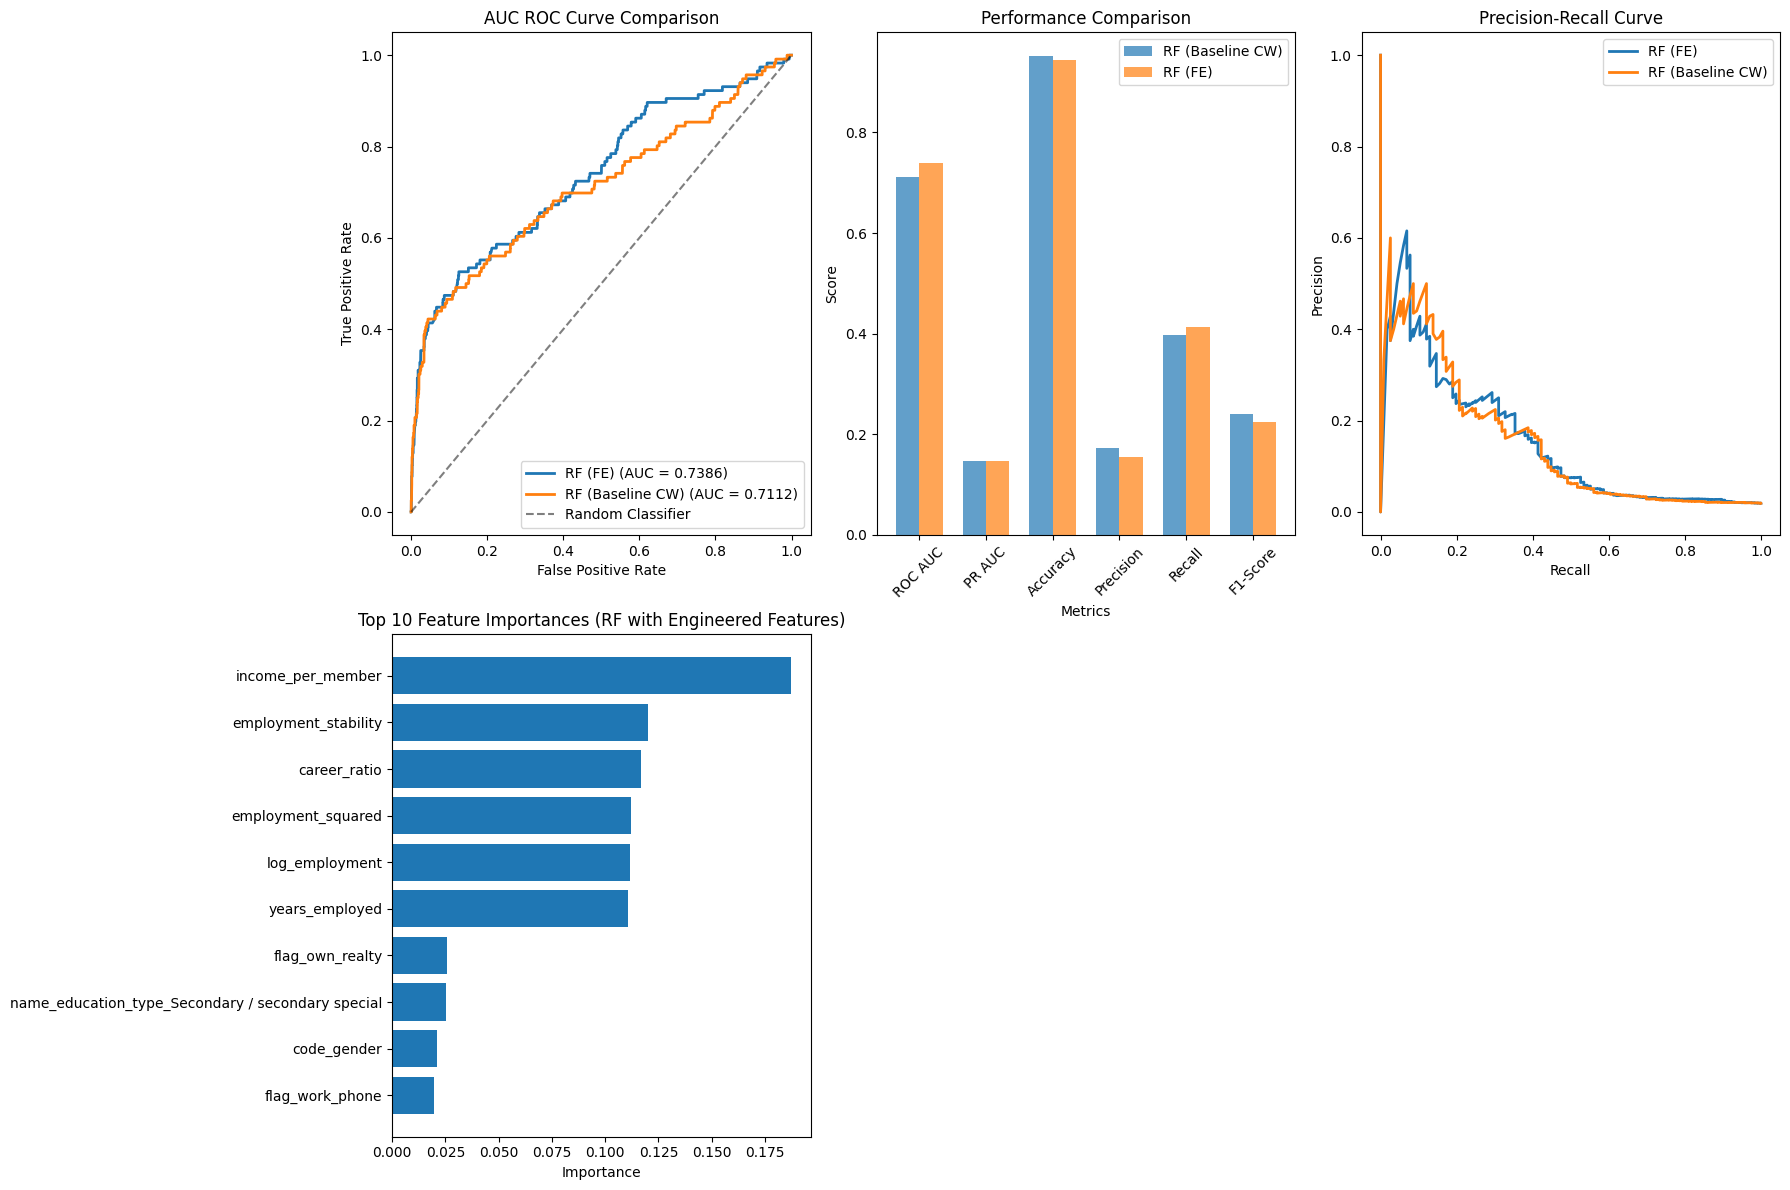

In [28]:
plt.figure(figsize=(18, 12))

# auc roc curve comparison plot
plt.subplot(2, 3, 1)
fpr_eng, tpr_eng, _ = roc_curve(y_test, y_pred_proba_eng)
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_cw)

plt.plot(fpr_eng, tpr_eng, label=f'RF (FE) (AUC = {results_eng["roc_auc"]:.4f})', linewidth=2)
plt.plot(fpr_base, tpr_base, label=f'RF (Baseline CW) (AUC = {results_cw["roc_auc"]:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC ROC Curve Comparison')
plt.legend()




# performance metrics comparison plot
plt.subplot(2, 3, 2)
metrics = ['ROC AUC', 'PR AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
base_values = [results_cw['roc_auc'], results_cw['pr_auc'],results_cw['accuracy'], results_cw['precision'], 
               results_cw['recall'], results_cw['f1']]
eng_values = [results_eng['roc_auc'], results_cw['pr_auc'], results_eng['accuracy'], results_eng['precision'], 
              results_eng['recall'], results_eng['f1']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, base_values, width, label='RF (Baseline CW)', alpha=0.7)
plt.bar(x + width/2, eng_values, width, label='RF (FE)', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.xticks(x, metrics, rotation=45)
plt.legend()


# precision recall curve plot
plt.subplot(2, 3, 3)
precision_eng, recall_eng, _ = precision_recall_curve(y_test, y_pred_proba_eng)
precision_base, recall_base, _ = precision_recall_curve(y_test, y_pred_proba_cw)

plt.plot(recall_eng, precision_eng, label='RF (FE)', linewidth=2)
plt.plot(recall_base, precision_base, label='RF (Baseline CW)', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()


#  feature importance plot (show new features)
plt.subplot(2, 3, 4)
feature_importance_eng = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_engineered.feature_importances_
}).sort_values('importance', ascending=False)
top_features_eng = feature_importance_eng.head(10)

plt.barh(top_features_eng['feature'][::-1], 
         top_features_eng['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (RF with Engineered Features)')
plt.tight_layout()
plt.show()



## 3. XGBOOST Model

#### 3.1 XGBoost Model (version 1)

Rationale of XGBoost with `scale_pos_weight` & regularisation:
- Class imbalance handling using `scale_pos_weight = (# negatives / # positives)` which penalises mistakes on minority class more (defaulters). This would improve recall on the minority (defaulters).
- Regularisation using `reg_alpha = 0.1` and `reg_lambda = 0.1` to reduce overfitting 

We chose log loss as the evaluation metric, because it trains XGBoost to penalise the model for being confidently wrong (in this case wrongly predicting defaulters as non-defaulters). 

In [29]:

## XGBoost (with Scale Pos Weight) and with regularisation

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=15,   
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    eval_metric='logloss'
)

# Train
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")


# Basic metrics
auc = roc_auc_score(y_test, y_pred_proba_xgb)
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
print(f"\nConfusion Matrix:")
print(cm)

print("\n Classification Report")
print(classification_report(y_test, y_pred_xgb))

# Rates
total_0 = cm[0,0] + cm[0,1]
total_1 = cm[1,0] + cm[1,1]
print("\nRates:")
print(f"Specificity: {cm[0,0]/total_0:.4f}")
print(f"False Positive Rate: {cm[0,1]/total_0:.4f}")
print(f"Sensitivity (Recall): {cm[1,1]/total_1:.4f}")
print(f"False Negative Rate: {cm[1,0]/total_1:.4f}")



Cross-Validation AUC: 0.7059 (+/- 0.0294)
AUC: 0.7336
Accuracy: 0.9542

Confusion Matrix:
[[5674  210]
 [  65   51]]

 Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      5884
           1       0.20      0.44      0.27       116

    accuracy                           0.95      6000
   macro avg       0.59      0.70      0.62      6000
weighted avg       0.97      0.95      0.96      6000


Rates:
Specificity: 0.9643
False Positive Rate: 0.0357
Sensitivity (Recall): 0.4397
False Negative Rate: 0.5603


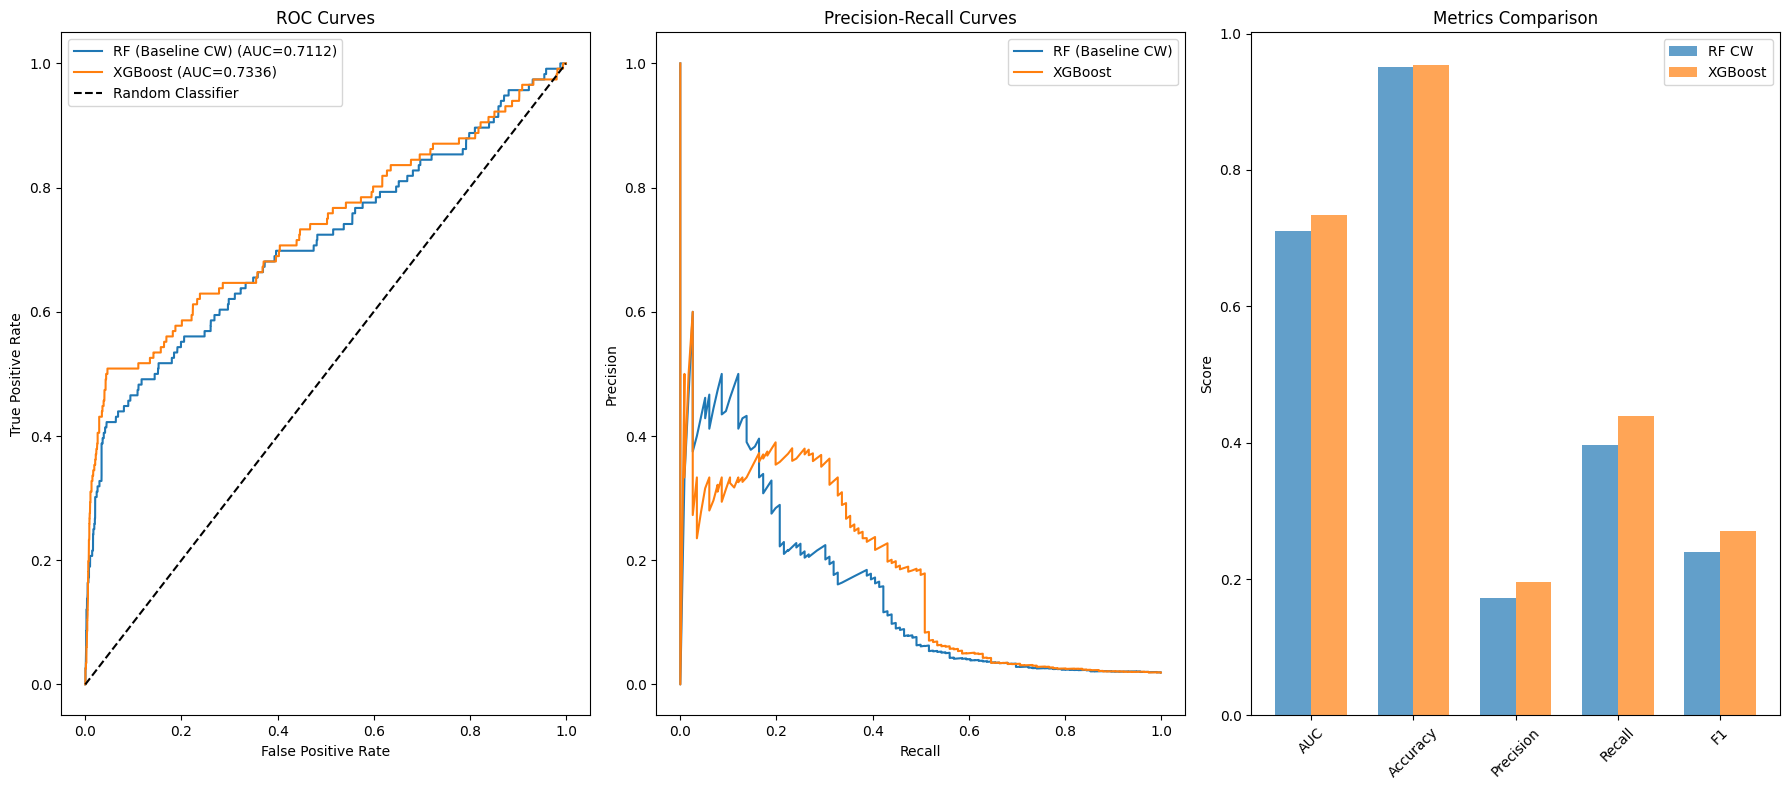

In [30]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

rf_metrics = {
    'AUC': roc_auc_score(y_test, y_pred_proba_cw),
    'Accuracy': accuracy_score(y_test, y_pred_cw),
    'Precision': precision_score(y_test, y_pred_cw),
    'Recall': recall_score(y_test, y_pred_cw),
    'F1': f1_score(y_test, y_pred_cw)
}

xgb_metrics = {
    'AUC': roc_auc_score(y_test, y_pred_proba_xgb),
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1': f1_score(y_test, y_pred_xgb)
}

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
import numpy as np

plt.figure(figsize=(18, 8))

# ROC Curve
plt.subplot(1, 3, 1)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_cw)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.plot(fpr_rf, tpr_rf, label=f'RF (Baseline CW) (AUC={rf_metrics["AUC"]:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_metrics["AUC"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()


# Precision-Recall Curve
plt.subplot(1, 3, 2)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_cw)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)

plt.plot(recall_rf, precision_rf, label='RF (Baseline CW)')
plt.plot(recall_xgb, precision_xgb, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()


# Metrics Comparison
plt.subplot(1, 3, 3)
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
rf_values = [rf_metrics[m] for m in metrics]
xgb_values = [xgb_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width/2, rf_values, width, label='RF CW', alpha=0.7)
plt.bar(x + width/2, xgb_values, width, label='XGBoost', alpha=0.7)
plt.xticks(x, metrics, rotation=45)
plt.ylabel('Score')
plt.title('Metrics Comparison')
plt.legend()


plt.tight_layout()
plt.show()

#### 3.2 Exploratory Hyperparameter Trace to get optimal no. of trees, max_depth, min_samples_leaf 

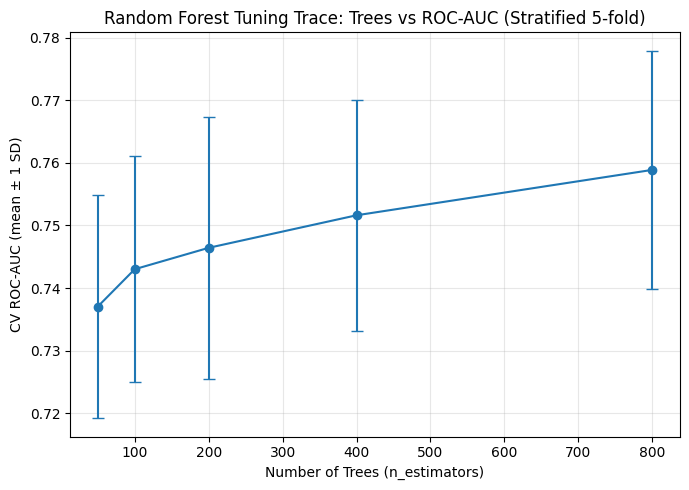

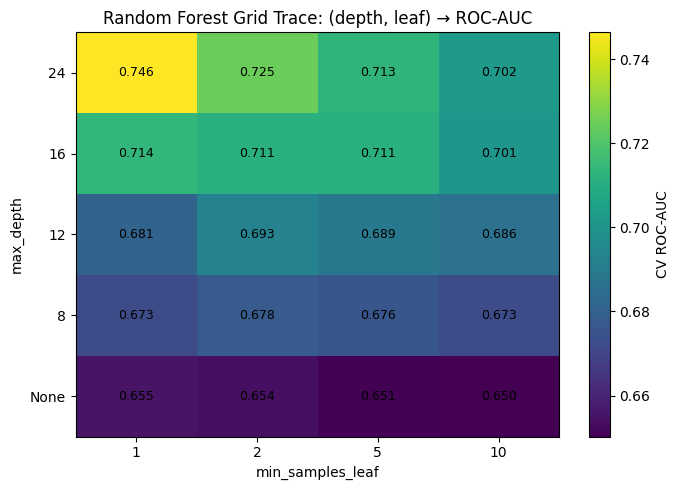

In [31]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_list = [50, 100, 200, 400, 800]
means, stds = [], []

for n in n_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=42,
        class_weight='balanced',   # keep the same imbalance strategy you used elsewhere
        n_jobs=-1
    )
    cv = cross_val_score(rf, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    means.append(cv.mean())
    stds.append(cv.std())

plt.figure(figsize=(7,5))
plt.errorbar(n_list, means, yerr=stds, fmt='-o', capsize=4)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("CV ROC-AUC (mean ± 1 SD)")
plt.title("Random Forest Tuning Trace: Trees vs ROC-AUC (Stratified 5-fold)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---- heatmap over (max_depth, min_samples_leaf) ---- 
depth_grid = [None, 8, 12, 16, 24]
leaf_grid  = [1, 2, 5, 10]

records = []
for d in depth_grid:
    for leaf in leaf_grid:
        rf = RandomForestClassifier(
            n_estimators=200,       # fix a reasonable value from the trace above
            max_depth=d,
            min_samples_leaf=leaf,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        cv = cross_val_score(rf, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
        records.append({
            "max_depth": ("None" if d is None else d),
            "min_samples_leaf": leaf,
            "auc_mean": cv.mean()
        })

df_grid = pd.DataFrame(records)
pivot = df_grid.pivot(index="max_depth", columns="min_samples_leaf", values="auc_mean")

plt.figure(figsize=(7,5))
im = plt.imshow(pivot.values, aspect='auto', origin='lower')
plt.colorbar(im, label="CV ROC-AUC")
plt.xticks(ticks=np.arange(len(leaf_grid)), labels=leaf_grid)
plt.yticks(ticks=np.arange(len(depth_grid)), labels=[("None" if d is None else d) for d in depth_grid])
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.title("Random Forest Grid Trace: (depth, leaf) → ROC-AUC")
# annotate cells
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        plt.text(j, i, f"{pivot.values[i,j]:.3f}", ha='center', va='center', fontsize=9)
plt.tight_layout()
plt.show()

#### 3.3 Tuned XGBoost (version 2) with new optimised parameters 

In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, auc, average_precision_score
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV


# =========================
# Helper: evaluation 
# =========================
def evaluate_model(model_name, y_true, y_pred, y_pred_proba):
    print(f"\n--- {model_name.upper()} EVALUATION ---")
    # ROC AUC and PR AUC
    auc = roc_auc_score(y_true, y_pred_proba)
    ap = average_precision_score(y_true, y_pred_proba)
    acc = accuracy_score(y_true, y_pred)
    print(f"ROC AUC: {auc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"PR AUC: {ap:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix")
    print(cm)

    # Classification Report
    print("\nClassification Report")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Return metrics dict (optional, for collection)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {
        'model': model_name, 'auc': auc, 'pr_auc': ap, 'accuracy': acc,
        'precision': prec, 'recall': rec, 'f1': f1, 'confusion_matrix': cm
    }


# Class weight & CV
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

########### 1. GRIDSEARCH MODEL ###########
xgb_opt_base = XGBClassifier(
    scale_pos_weight=pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [300],          
    "max_depth": [16, 20, 24],      
    "min_child_weight": [1, 2],     
    "learning_rate": [0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "reg_alpha": [0.0, 0.1],        
    "reg_lambda": [0.0, 0.1]        
}

grid_optimised = GridSearchCV(
    estimator=xgb_opt_base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=skf,
    n_jobs=-1,
    verbose=2
)

grid_optimised.fit(X_train_selected, y_train)
best_xgb = grid_optimised.best_estimator_

y_pred_xgb_v2  = best_xgb.predict(X_test_selected)
y_proba_xgb_v2 = best_xgb.predict_proba(X_test_selected)[:, 1]


print("\n========================")
print(" GRIDSEARCH XGBOOST")
print("========================")
_ = evaluate_model(
    "XGBoost (GridSearch)",
    y_test,
    y_pred_xgb_v2,
    y_proba_xgb_v2
)



Fitting 5 folds for each of 24 candidates, totalling 120 fits

 GRIDSEARCH XGBOOST

--- XGBOOST (GRIDSEARCH) EVALUATION ---
ROC AUC: 0.7319
Accuracy: 0.9337
PR AUC: 0.1629

Confusion Matrix
[[5552  332]
 [  66   50]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      5884
           1       0.13      0.43      0.20       116

    accuracy                           0.93      6000
   macro avg       0.56      0.69      0.58      6000
weighted avg       0.97      0.93      0.95      6000



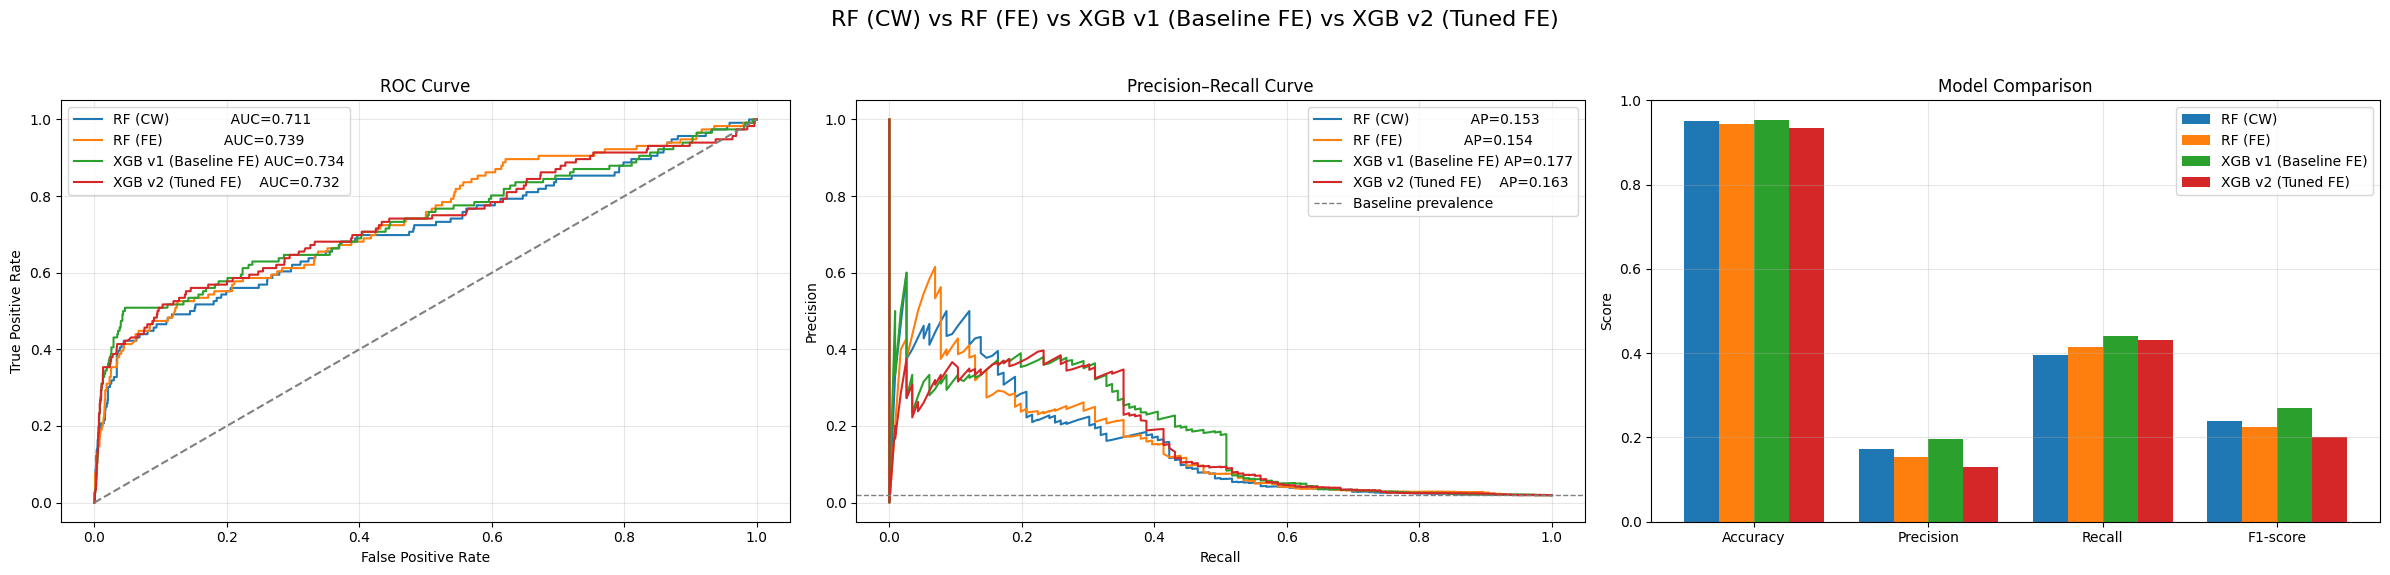

In [38]:
# ============================================================
# PLOTS: ROC, PR, METRIC BAR CHART
# ============================================================

# Baseline RF (class-weighted)
rf_pred   = y_pred_cw
rf_proba  = y_pred_proba_cw


# RF (with FE)
rf_fe_pred  = y_pred_eng
rf_fe_proba = y_pred_proba_eng

# XGBoost (baseline with FE) - v1
xgb_v1_pred  = y_pred_xgb
xgb_v1_proba = y_pred_proba_xgb 

# Tuned XGBoost (with FE) - v2
xgb_v2_pred  = y_pred_xgb_v2
xgb_v2_proba = y_proba_xgb_v2

# ---- ROC Curves ----
fpr_rf,    tpr_rf,    _ = roc_curve(y_test, rf_proba)
fpr_rf_fe, tpr_rf_fe, _ = roc_curve(y_test, rf_fe_proba)
fpr_xgb_v1, tpr_xgb_v1, _ = roc_curve(y_test, xgb_v1_proba)
fpr_xgb_v2, tpr_xgb_v2, _ = roc_curve(y_test, xgb_v2_proba)

auc_rf     = roc_auc_score(y_test, rf_proba)
auc_rf_fe  = roc_auc_score(y_test, rf_fe_proba)
auc_xgb_v1 = roc_auc_score(y_test, xgb_v1_proba)
auc_xgb_v2 = roc_auc_score(y_test, xgb_v2_proba)

# ---- Precision–Recall Curves ----
prec_rf,    recall_rf,    _ = precision_recall_curve(y_test, rf_proba)
prec_rf_fe, recall_rf_fe, _ = precision_recall_curve(y_test, rf_fe_proba)
prec_xgb_v1, recall_xgb_v1, _ = precision_recall_curve(y_test, xgb_v1_proba)
prec_xgb_v2, recall_xgb_v2, _ = precision_recall_curve(y_test, xgb_v2_proba)

ap_rf     = average_precision_score(y_test, rf_proba)
ap_rf_fe  = average_precision_score(y_test, rf_fe_proba)
ap_xgb_v1 = average_precision_score(y_test, xgb_v1_proba)
ap_xgb_v2 = average_precision_score(y_test, xgb_v2_proba)

# ---- Metrics Table for Bar Plot ----
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

rf_scores = [
    accuracy_score(y_test, rf_pred),
    precision_score(y_test, rf_pred, zero_division=0),
    recall_score(y_test, rf_pred, zero_division=0),
    f1_score(y_test, rf_pred, zero_division=0)
]

rf_fe_scores = [
    accuracy_score(y_test, rf_fe_pred),
    precision_score(y_test, rf_fe_pred, zero_division=0),
    recall_score(y_test, rf_fe_pred, zero_division=0),
    f1_score(y_test, rf_fe_pred, zero_division=0)
]

xgb_v1_scores = [
    accuracy_score(y_test, xgb_v1_pred),
    precision_score(y_test, xgb_v1_pred, zero_division=0),
    recall_score(y_test, xgb_v1_pred, zero_division=0),
    f1_score(y_test, xgb_v1_pred, zero_division=0)
]

xgb_v2_scores = [
    accuracy_score(y_test, xgb_v2_pred),
    precision_score(y_test, xgb_v2_pred, zero_division=0),
    recall_score(y_test, xgb_v2_pred, zero_division=0),
    f1_score(y_test, xgb_v2_pred, zero_division=0)
]

df_metrics = pd.DataFrame({
    "Metric": metrics,
    "RF (CW)": rf_scores,
    "RF (FE)": rf_fe_scores,
    "XGB v1 (Baseline FE)": xgb_v1_scores,
    "XGB v2 (Tuned FE)": xgb_v2_scores
})

# ============================================================
# VISUALISATIONS
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# (1) ROC Curve
axes[0].plot(fpr_rf,     tpr_rf,     label=f"RF (CW)              AUC={auc_rf:.3f}")
axes[0].plot(fpr_rf_fe,  tpr_rf_fe,  label=f"RF (FE)              AUC={auc_rf_fe:.3f}")
axes[0].plot(fpr_xgb_v1, tpr_xgb_v1, label=f"XGB v1 (Baseline FE) AUC={auc_xgb_v1:.3f}")
axes[0].plot(fpr_xgb_v2, tpr_xgb_v2, label=f"XGB v2 (Tuned FE)    AUC={auc_xgb_v2:.3f}")
axes[0].plot([0, 1], [0, 1], linestyle="--", color='gray')
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# (2) Precision–Recall Curve
axes[1].plot(recall_rf,     prec_rf,     label=f"RF (CW)              AP={ap_rf:.3f}")
axes[1].plot(recall_rf_fe,  prec_rf_fe,  label=f"RF (FE)              AP={ap_rf_fe:.3f}")
axes[1].plot(recall_xgb_v1, prec_xgb_v1, label=f"XGB v1 (Baseline FE) AP={ap_xgb_v1:.3f}")
axes[1].plot(recall_xgb_v2, prec_xgb_v2, label=f"XGB v2 (Tuned FE)    AP={ap_xgb_v2:.3f}")
axes[1].axhline((y_test==1).mean(), ls='--', c='gray', lw=1, label='Baseline prevalence')
axes[1].set_title("Precision–Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# (3) Bar Plot (Accuracy, Precision, Recall, F1)
x = np.arange(len(metrics))
width = 0.2
axes[2].bar(x - 1.5*width, df_metrics["RF (CW)"], width, label="RF (CW)")
axes[2].bar(x - 0.5*width, df_metrics["RF (FE)"], width, label="RF (FE)")
axes[2].bar(x + 0.5*width, df_metrics["XGB v1 (Baseline FE)"], width, label="XGB v1 (Baseline FE)")
axes[2].bar(x + 1.5*width, df_metrics["XGB v2 (Tuned FE)"], width, label="XGB v2 (Tuned FE)")
axes[2].set_xticks(x)
axes[2].set_xticklabels(metrics)
axes[2].set_ylabel("Score")
axes[2].set_ylim(0, 1)
axes[2].set_title("Model Comparison")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle("RF (CW) vs RF (FE) vs XGB v1 (Baseline FE) vs XGB v2 (Tuned FE)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [39]:
print("\n========================")
print(" RANDOM FOREST (Class-Weighted)")
print("========================")
_ = evaluate_model(
    "Random Forest (CW)",
    y_test,
    rf_pred,
    rf_proba
)

print("\n========================")
print(" RANDOM FOREST (with Feature Engineering)")
print("========================")
_ = evaluate_model(
    "Random Forest (FE)",
    y_test,
    rf_fe_pred,
    rf_fe_proba
)

print("\n========================")
print(" XGBOOST (Baseline v1, with Feature Engineering)")
print("========================")
_ = evaluate_model(
    "XGBoost (Tuned v1 FE)",
    y_test,
    xgb_v1_pred,
    xgb_v1_proba
)

print("\n========================")
print(" XGBOOST (Tuned v2, with Feature Engineering)")
print("========================")
_ = evaluate_model(
    "XGBoost (Tuned v2 FE)",
    y_test,
    xgb_v2_pred,
    xgb_v2_proba
)



 RANDOM FOREST (Class-Weighted)

--- RANDOM FOREST (CW) EVALUATION ---
ROC AUC: 0.7112
Accuracy: 0.9515
PR AUC: 0.1530

Confusion Matrix
[[5663  221]
 [  70   46]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5884
           1       0.17      0.40      0.24       116

    accuracy                           0.95      6000
   macro avg       0.58      0.68      0.61      6000
weighted avg       0.97      0.95      0.96      6000


 RANDOM FOREST (with Feature Engineering)

--- RANDOM FOREST (FE) EVALUATION ---
ROC AUC: 0.7386
Accuracy: 0.9447
PR AUC: 0.1535

Confusion Matrix
[[5620  264]
 [  68   48]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      5884
           1       0.15      0.41      0.22       116

    accuracy                           0.94      6000
   macro avg       0.57      0.68      0.60      6000
weighted avg   

In the context of credit default prediction, it is crucial to find the right balance between identifying true defaulters and minimizing false alarms. The precision-recall curve is a valuable tool for visualizing this trade-off, as it shows how precision (the proportion of correctly identified defaulters among all predicted defaulters) and recall (the proportion of actual defaulters correctly identified by the model) change as we adjust the classification threshold. In practical terms, if our main concern is to avoid lending to customers who are likely to default, we may prioritize a higher recall, accepting a greater number of false positives to ensure we capture as many defaulters as possible. Conversely, if we want to avoid mistakenly classifying reliable customers as risky, we might set a higher threshold to achieve higher precision, even if it means some defaulters go undetected. By analyzing the precision-recall curve, we can select a threshold that aligns with our institution’s risk appetite and business objectives, ensuring our credit decision process is both responsible and aligned with our strategic goals.


### 4. Training Loss vs Validation Loss
Training loss and validation loss curves are line plots that show how well a machine learning model is learning over time (epochs or iterations) for both the data it was trained on and unseen data.

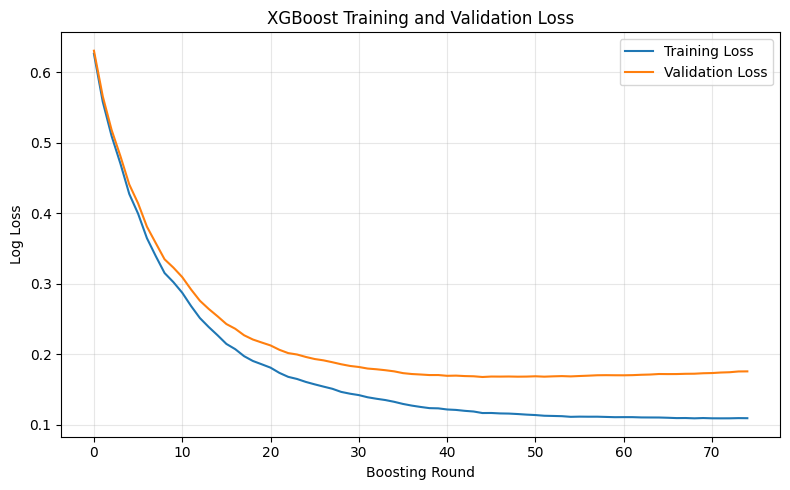

In [40]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_selected, y_train, test_size=0.2,
    stratify=y_train, random_state=42
)

# Convert to DMatrix 
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval   = xgb.DMatrix(X_val, label=y_val)

# Extract best hyperparams manually from best_xgb
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": best_xgb.max_depth,
    "min_child_weight": best_xgb.min_child_weight,
    "learning_rate": best_xgb.learning_rate,
    "subsample": best_xgb.subsample,
    "colsample_bytree": best_xgb.colsample_bytree,
    "reg_alpha": best_xgb.reg_alpha,
    "reg_lambda": best_xgb.reg_lambda,
    "scale_pos_weight": best_xgb.scale_pos_weight
}

# Train
evals_result = {}
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_xgb.n_estimators,
    evals=[(dtrain, "train"), (dval, "validation")],
    early_stopping_rounds=30,
    evals_result=evals_result,
    verbose_eval=False
)

# Plot training and validation loss curves
plt.figure(figsize=(8,5))
plt.plot(evals_result["train"]["logloss"], label="Training Loss")
plt.plot(evals_result["validation"]["logloss"], label="Validation Loss")
plt.xlabel("Boosting Round")
plt.ylabel("Log Loss")
plt.title("XGBoost Training and Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
